In [1]:
import torch
import util
import custum_dataset
from torch.utils.data import DataLoader
from model import Model
import torch.optim.lr_scheduler as lr_scheduler


In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
path = f'C:/Users/yy/Desktop/dl_project/data/data.txt'  

c = util.config()

data_train,stoi,itos = util.load_data_with_split(path,c.split,type='train')
data_test,_,_ = util.load_data_with_split(path,c.split,type='test')


dataset_train = custum_dataset.CustomDataset(c.sequence_l,device,stoi,itos,data_train,repeat = False)
data_loader_train = DataLoader(dataset_train, c.batch_size, shuffle=False)

dataset_test = custum_dataset.CustomDataset(c.sequence_l,device,stoi,itos,data_test,repeat = False)
data_loader_test = DataLoader(dataset_test, c.batch_size, shuffle=False)

model = Model(stoi=dataset_train.stoi)
m = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=c.learning_rate)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer,mode='min', factor=0.1, patience=5)



# Training loop
lr decay: https://pytorch.org/docs/stable/optim.html

In [3]:
train_loss = []
test_loss = []
perplexity_train = []
perplexity_test = []

num_epochs = 400

for epoch in range(num_epochs):

    m.train()

    inputs, targets = next(iter(data_loader_train))

    optimizer.zero_grad()
    
    logit, loss, perplexity = model(inputs, use='train', y=targets)

    loss.backward()
    optimizer.step()

    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {loss:.4f}, Perplexity: {perplexity:.4f}")

    # eval 
    m.eval()

    with torch.no_grad():
        inputs_t, targets_t = next(iter(data_loader_test))

        # Forward pass
        logit, valid_loss, valid_perplexity = model(inputs, use='train', y=targets)

    print(f"Validation Loss: {valid_loss:.4f}, Validation Perplexity: {valid_perplexity:.4f}")


    train_loss.append(loss.cpu().detach().numpy())
    test_loss.append(valid_loss.cpu().detach().numpy())
    perplexity_train.append(perplexity.cpu().detach().numpy())
    perplexity_test.append(valid_perplexity.cpu().detach().numpy())

    scheduler.step(valid_loss)


Epoch 1/400, Loss: 4.2754, Perplexity: 71.9083
Validation Loss: 4.5628, Validation Perplexity: 95.8520
Epoch 2/400, Loss: 4.5098, Perplexity: 90.9033
Validation Loss: 4.3617, Validation Perplexity: 78.3875
Epoch 3/400, Loss: 4.3310, Perplexity: 76.0232
Validation Loss: 4.2759, Validation Perplexity: 71.9438
Epoch 4/400, Loss: 4.2612, Perplexity: 70.8964
Validation Loss: 4.2592, Validation Perplexity: 70.7565
Epoch 5/400, Loss: 4.2519, Perplexity: 70.2421
Validation Loss: 4.0963, Validation Perplexity: 60.1185
Epoch 6/400, Loss: 4.0961, Perplexity: 60.1054
Validation Loss: 3.9145, Validation Perplexity: 50.1247
Epoch 7/400, Loss: 3.9193, Perplexity: 50.3639
Validation Loss: 3.7410, Validation Perplexity: 42.1391
Epoch 8/400, Loss: 3.7491, Perplexity: 42.4817
Validation Loss: 3.5528, Validation Perplexity: 34.9118
Epoch 9/400, Loss: 3.5653, Perplexity: 35.3494
Validation Loss: 3.3412, Validation Perplexity: 28.2540
Epoch 10/400, Loss: 3.3595, Perplexity: 28.7744
Validation Loss: 3.1267, 

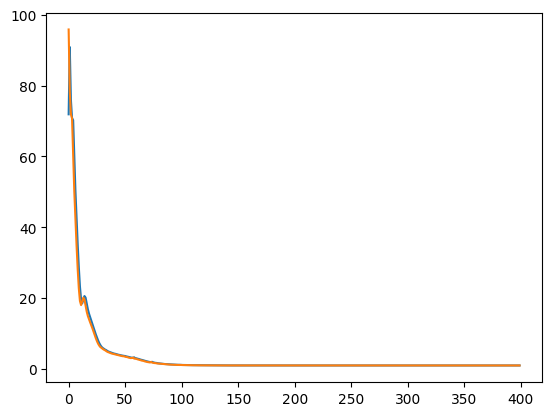

In [4]:
import matplotlib.pyplot as plt
import numpy as np
epoch_list = np.arange(0,len(train_loss))
plt.plot(epoch_list,perplexity_train)
plt.plot(epoch_list,perplexity_test)

array(0.01687288, dtype=float32)

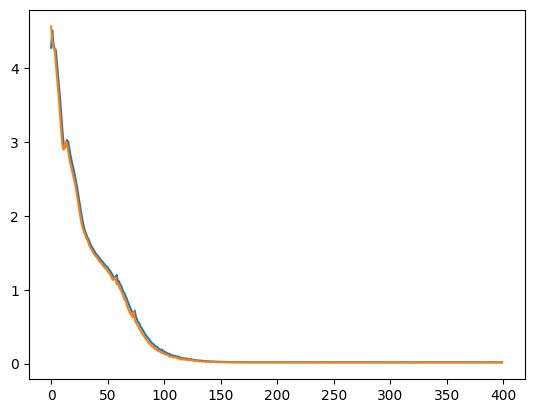

In [5]:
epoch_list = np.arange(0,len(train_loss))
plt.plot(epoch_list,train_loss)
plt.plot(epoch_list,test_loss)
min(train_loss)


# save model

In [9]:
# save model
from pathlib import Path

# 1. Create models directory 
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path 
MODEL_NAME = "400_step_decay_with_init_good.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state dict 
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=m.state_dict(), # only saving the state_dict() only saves the models learned parameters
           f=MODEL_SAVE_PATH) 

Saving model to: models\4000_step_decay_with_init_good.pth


In [10]:
MODEL_SAVE_PATH

WindowsPath('models/4000_step_decay_with_init_good.pth')

# load model

In [ ]:
m.load_state_dict(torch.load('models/4000_step_decay_with_init.pth'))


# generation:

In [6]:

seed = "I saw a cat jumping onto the table, "


input_idx = util.encode(seed,stoi)

input_idx = torch.tensor(input_idx,dtype=torch.long)
input_idx = torch.unsqueeze(input_idx, 0).to(device)


m.eval()
with torch.no_grad():
    out = m.generate(1000,input_idx,'hi')
    out = util.decode(out,itos)
    

with open('output400.txt', 'w') as file:
# Write the string to the file
    file.write(out)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [7]:
m.eval()
with torch.no_grad():
    out = m.generate(1000,input_idx,'high_prob')
    print(util.decode(out,itos))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27